<a href="https://colab.research.google.com/github/sizhky/AutoTrain/blob/master/nbs/auto_train_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
try:
    from icevision.all import *
except:
    !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
    !bash install_colab.sh

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.10.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:18


CPU times: user 28.7 s, sys: 669 ms, total: 29.4 s
Wall time: 29.3 s


In [ ]:
# %%capture
%load_ext autoreload
%autoreload 2

import os
if not os.path.exists('/content/AutoTrain'):
    !pip install -U torch-snippets typer imgaug
    !git clone https://github.com/sizhky/AutoTrain

from torch_snippets import *
if not P().stem == 'AutoTrain':
    %cd AutoTrain
    !git pull origin segmentation
    !git checkout segmentation

2021-08-25 13:55:55.345 | WARNING  | torch_snippets:<module>:14 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


/content/AutoTrain
From https://github.com/sizhky/AutoTrain
 * branch            segmentation -> FETCH_HEAD
Already up to date.
M	auto_train_segmentation/custom_functions.py
M	auto_train_segmentation/infer.py
M	auto_train_segmentation/train.py
M	config.ini
Already on 'segmentation'
Your branch is up to date with 'origin/segmentation'.


In [20]:
!cat config.ini

[project]
owner: sizhky
name: baloons
location: ${project.name}
model_directory: ${project.location}/models
type: segmentation
num_classes: 2
auto_train_lib: auto_train_${project.type}
classes: ["baloon"]

[architecture]
model_type: torchvision.mask_rcnn
backbone: resnet34_fpn
pretrained: True
size: 384
[architecture.extra_args]

[training]
dir: /content/drive/MyDrive/balloon
; folder should be exported from label studio, 
; in COCO format for segmentation, i.e., 
; it should have one images dir and one results.json file
images_dir: ${training.dir}/images
annotations_file: ${training.dir}/result.json
checkpoint: ${project.model_directory}/model.pt

train_ratio: 0.8
[training.preprocess]
@augmentations: get_train_transforms
size: ${architecture.size}
presize: 512

[training.data]
train_dir: ${training.dir}/train
validation_dir: ${training.dir}/validation

[training.scheme]
epochs: 300
lr: 1e-5
freeze_epochs: 5
output_path: ${project.model_directory}/model.pt

[testing]
[testing.preproce

In [ ]:
!python auto_train_segmentation/train.py

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.10.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:18
WARNING  - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego' | torch_snippets:<module>:14
100% 255/255 [00:00<00:00, 1312.27it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:136
100% 48/48 [00:00<00:00, 1963.74it/s]
100% 13/13 [00:00<00:00, 1986.81it/s]
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100% 83.3M/83.3M [00:00<00:00, 119MB/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Plea

In [14]:
from torch_snippets import *
from icevision.all import *
from auto_train_object_detection.custom_functions import *
from torch_snippets.registry import registry, Config, AttrDict

config = Config().from_disk('config.ini')
config = AttrDict(registry.resolve(config))

image_size = config.architecture.size
class_map = ClassMap(config.project.classes)

assert config.architecture.model_type.count('.', 1), "Architecture should look like <base>.<model>"
extra_args = config.architecture.extra_args
a, b = config.architecture.model_type.split('.')
model_type = getattr(getattr(models, a), b)
backbone = getattr(model_type.backbones, config.architecture.backbone)(config.architecture.pretrained)
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(class_map), **extra_args)

from torch_snippets import load_torch_model_weights_to, save_torch_model_weights_from, makedir
yolo_path = config.training.scheme.output_path
load_torch_model_weights_to(model, yolo_path, device='cpu')


INFO     - Loaded weights from baloons/models/model.pt to given model | __main__:<module>:21


In [17]:
folder = '/content/drive/MyDrive/balloon/validation'
fpaths = []
for extn in image_extns:
    fpaths += P(folder).Glob(f'*.{extn}')
imgs = [read(f, 1) for f in fpaths][:4]
logger.info(f'Found {len(imgs)} images')

infer_ds = Dataset.from_images(imgs, infer_tfms, class_map=class_map)
infer_dl = model_type.infer_dl(infer_ds, batch_size=1)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

INFO     - Found 13 images | __main__:<module>:6


  0%|          | 0/13 [00:00<?, ?it/s]

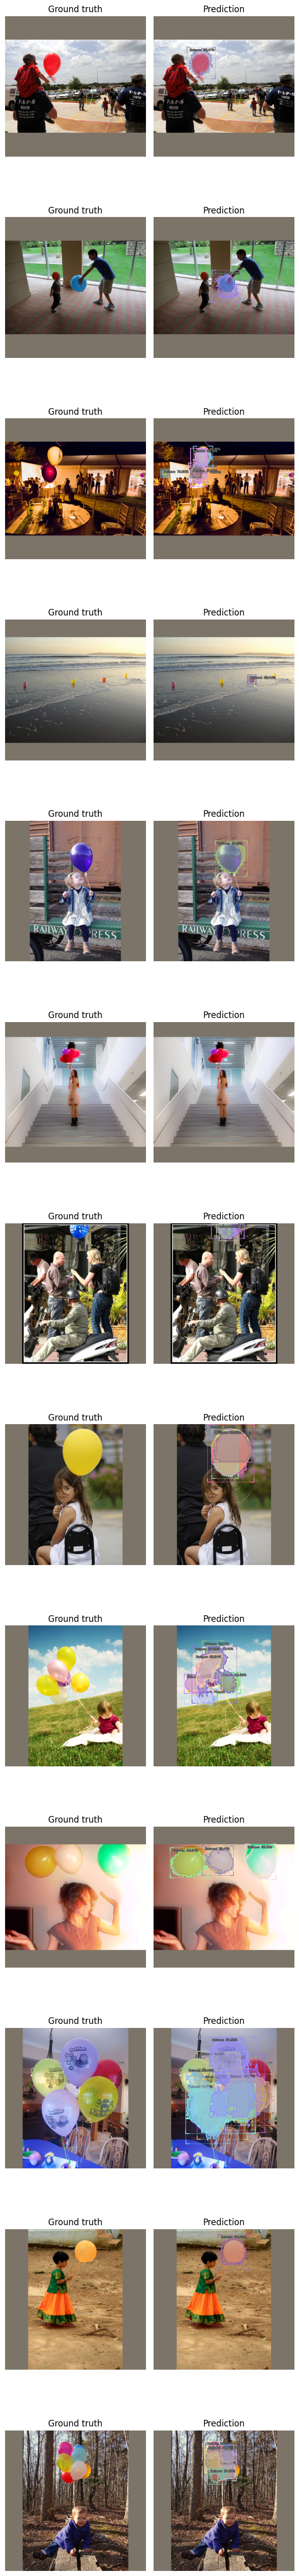

In [19]:
show_preds(preds=preds, ncols=3)

---